<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">

## The Bias-Variance Tradeoff

Week 3 | 4.1

---

This notebook aims to give a visual overview of the bias-variance tradeoff in model fitting.

Below we will be fitting models predicting student morale from the day number in the course. We have the "true function" representing the function from which any student in the population of all students measurements are generated (plus noise). 

The overall goal when building a model is to minimize the bias _and_ the variance. The perfect model would have zero bias and zero variance. In reality, the bias or the variance typically increase while the other decreases.


In [2]:
import numpy as np
import scipy 
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')


---

### Set up the days and morale variables

Below are the day numbers in the course and the morale function, which takes a day as an argument and returns a morale number.

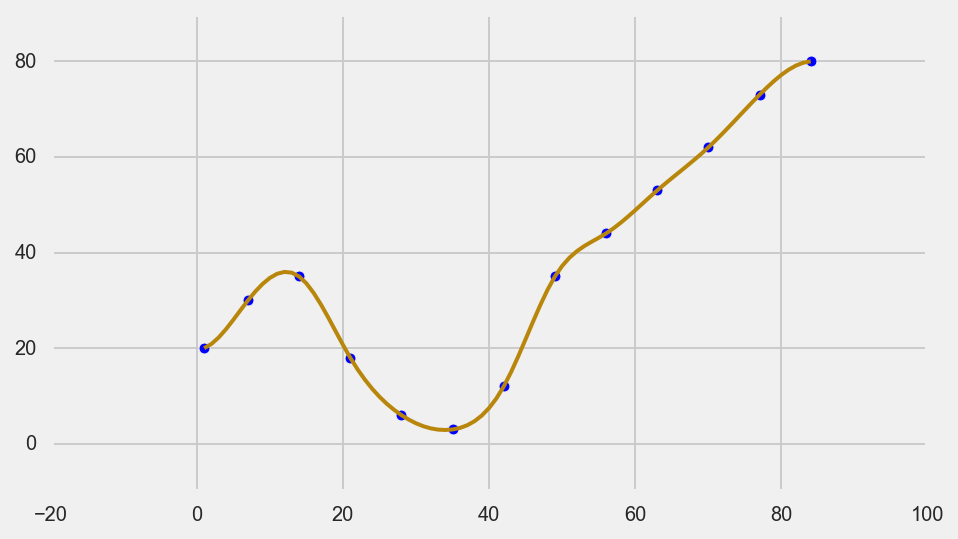

In [10]:
days = np.arange(1, 85, 1)
weekpoints = [1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]
moralepoints = [20, 30, 35, 18, 6, 3, 12, 35, 44, 53, 62, 73, 80]

morale_func = interp1d(weekpoints, moralepoints, kind='cubic')

morale_true = morale_func(days)


fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(weekpoints, moralepoints, s=30)
ax.plot(days, morale_true, lw=2, color='darkgoldenrod')
plt.show()

---

### Plot the true morale function

We can plot out the true function of days predicting morale. The true function represents:

1. What all morale measurements would be at each day if you had no noise in your measurements. 
2. The measurement of morale for any student prior to adding noise. In this way students are generated from the true function.
3. The average morale across an infinite number of students.

You will always have noise in measurements, it just depends how much. In the context of bias-variance tradeoff, this is referred to as "irreducible error", which are the deviations from the true function in your observations that cannot be accounted for by a model.

In [11]:
days

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])

---

### Generate a sample of students from the true function

Each student has had their morale checked 12 different times throughout the course, but not necessarily at the same times.

In [12]:
def make_students(morale_func, days, size=12):
    students = {}
    for student in ['A','B','C','D']:
        day_sample = np.random.choice(days, replace=False, size=size)
        morale = morale_func(day_sample) + np.random.normal(0, 13, size=size)
        students[student] = {'days':day_sample, 'morale':morale}
    return students

In [13]:
students = make_students(morale_func, days)
students

{'A': {'days': array([ 4, 61, 64, 48,  9, 56, 40, 63, 69, 78, 74, 32]),
  'morale': array([ 42.33877401,  40.78198397,  89.03778778,  41.35563888,
          28.31136934,  38.31838619,  -5.94906522,  66.25648622,
          50.79119834,  78.77164533,  80.38493901,  21.40914763])},
 'B': {'days': array([68, 66, 56, 52, 55, 44, 59, 71, 82, 54, 53, 64]),
  'morale': array([ 47.78939989,  63.98323975,  45.01154258,  33.06624755,
          55.98259552,  -2.17547125,  54.56594357,  65.96603316,
          75.47662526,  43.70407307,  53.04003747,  53.81741144])},
 'C': {'days': array([83, 37, 18, 32, 60, 51, 13, 21, 63, 27, 79, 61]),
  'morale': array([ 59.44121697,  -7.28382918,  28.87768539,  22.0143528 ,
          63.60458433,  15.22689104,  62.59413679,   9.51771506,
          70.58697894,   4.7408805 ,  67.13199595,  45.21869068])},
 'D': {'days': array([68, 47, 64, 77, 70, 72, 16, 52, 41, 67, 18, 48]),
  'morale': array([ 35.99615446,  45.36146854,  57.14998783,  48.69780344,
          81.

---

### Student A's morale over time

Plot of student A's morale over the days. The true function is also plotted in yellow.

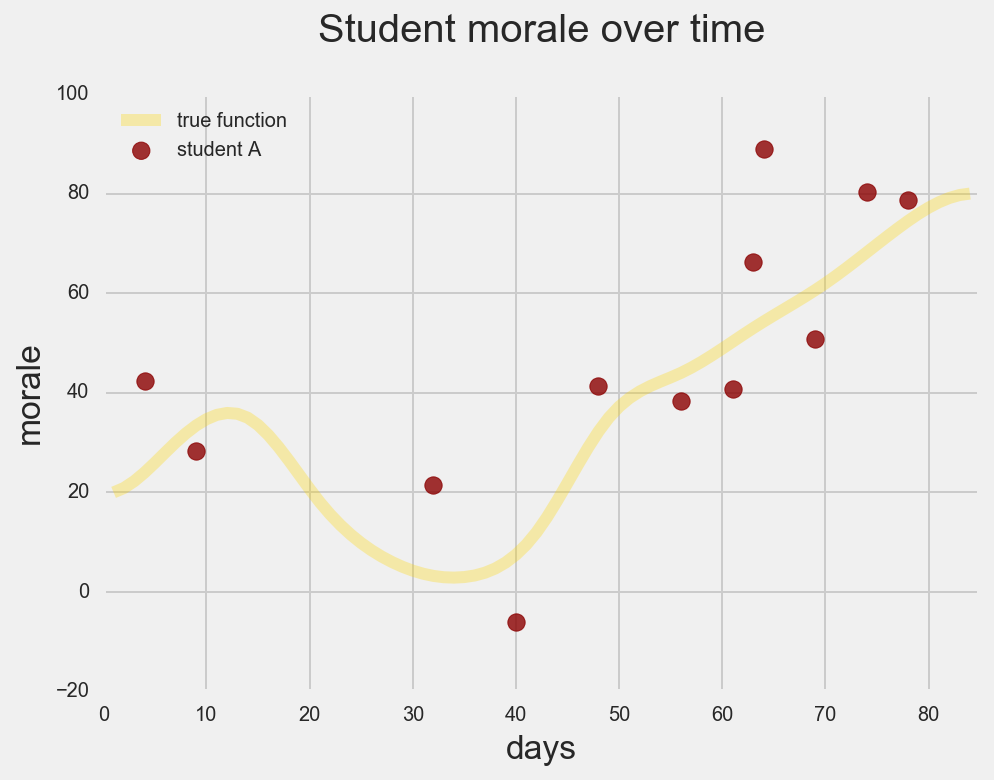

In [16]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(days, morale_true, lw=6, color='gold', alpha=0.3, label='true function')
ax.scatter(students['A']['days'], students['A']['morale'],
           s=75, color='darkred', label='student A', alpha=0.8)

ax.set_xlabel('days')
ax.set_ylabel('morale')
ax.set_title('Student morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')
plt.show()


---

### Construct a model from student A

I decide to measure the morale with a linear regression, predicting it from the number of days. 

My model is:

### $$\hat{morale} = \beta_0 + \beta_1days$$

In [20]:
A_days = students['A']['days']
A_days = A_days[:, np.newaxis]
#print A_days
A_morale = students['A']['morale']

A_model = LinearRegression()
A_model.fit(A_days, A_morale)

print A_model.intercept_, A_model.coef_

13.2508263565 [ 0.69029829]


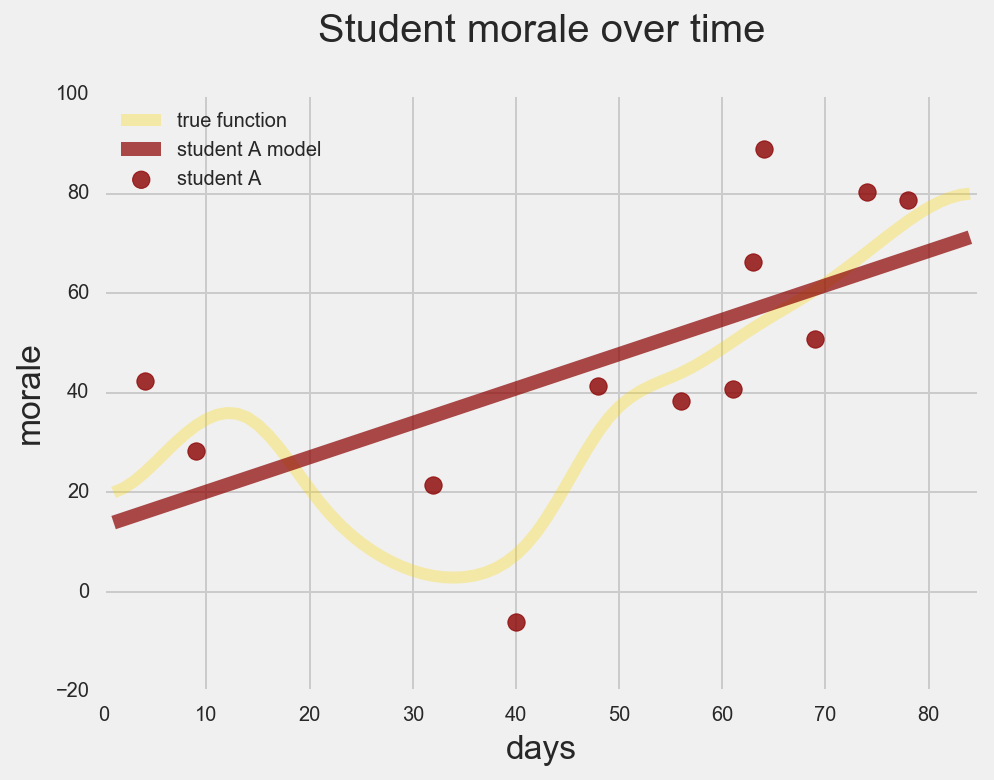

In [21]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(days, morale_true, lw=6, color='gold', alpha=0.3, label='true function')
ax.scatter(students['A']['days'], students['A']['morale'],
           s=75, color='darkred', label='student A', alpha=0.8)

ax.plot(days, A_model.predict(days[:, np.newaxis]),
        lw=7, color='darkred', alpha=0.7, label='student A model')

ax.set_xlabel('days')
ax.set_ylabel('morale')
ax.set_title('Student morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')
plt.show()

---

### Total error of model

In total we have three sources of error in our model that comprise the errors of our predictions:

### $$\text{Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

### $$E\Big[\big(y - \hat{f}(x)\big)^2\Big] = \text{Bias}\big[\;\hat{f}(x)\;\big]^2 + \text{Var}\big[\;\hat{f}(x)\;\big] + \sigma^2 $$

Where $\hat{f}(x)$ represents our model **across multiple samples of the population $x$, as in, samples $x_1$ through $x_n$**.

---

### Bias

The $bias^2$ is one source of error in our model. It is the error for how much average predictions of morale across the observations at each day deviate from the true "morale function".

### $$Bias^2 = \big(E[F_{sample}(x)] - F_{true}(x)\big)^2$$

Which can also be written as:

### $$ \text{Bias}\big[\;\hat{f}(x)\;\big] = \text{E}\big[\;\hat{f}(x) - f(x)\;\big] $$

**For samples of the population $x_1$ to $x_n$.**

The squared bias is a number that essentially describes our model's assumption of how simple the true function is. 

A higher squared bias means we are assuming that variance in our prediction errors is due more to noise than _actual_ variance in the observations.

**Remember, it is over multiple samples.**

It only makes sense to think of bias in terms of predictions we make across multiple samples on new data.

1. The bias is estimated for an $x$ that is unseen: the bias of the model on a test set of data.
2. The expected value of the extimated function minus the true function can be measured over multiple different random training sets of our data using cross-validation.

Since we have the true function in this example, we can plot and calculate the bias for just this one student. Typically you would need to _estimate_ the bias across multiple models and samples.

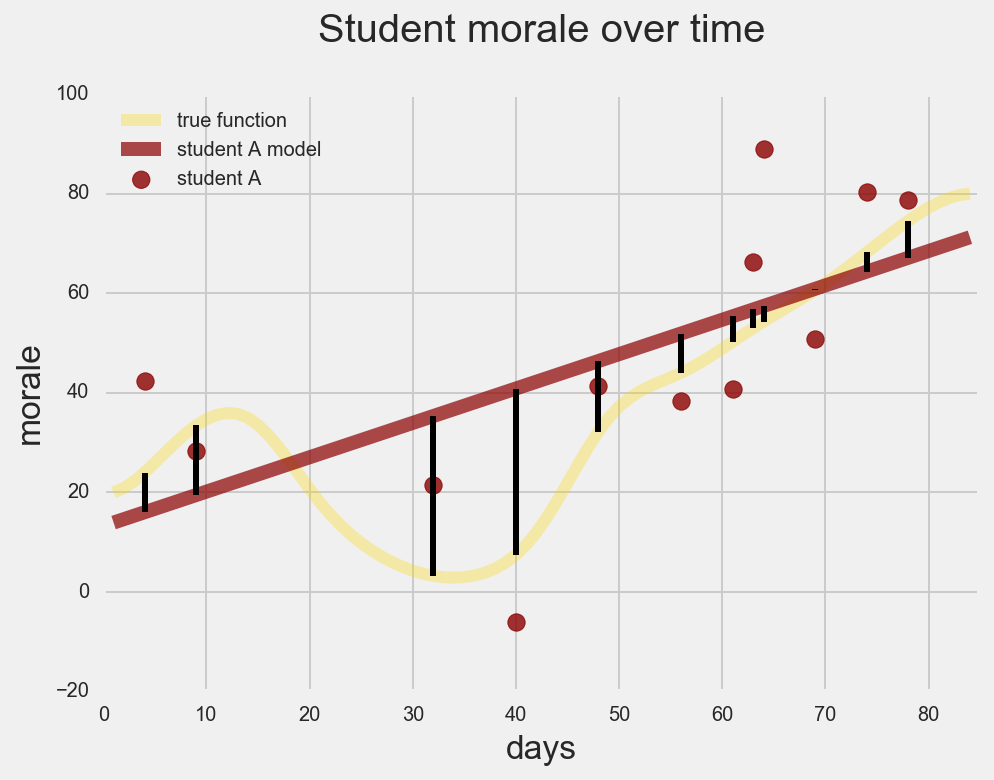

In [23]:
fig, ax = plt.subplots(figsize=(7,5))

A_pred = A_model.predict(days[:, np.newaxis])

ax.plot(days, morale_true, lw=6, color='gold', alpha=0.3, label='true function')
ax.scatter(students['A']['days'], students['A']['morale'],
           s=75, color='darkred', label='student A', alpha=0.8)

ax.plot(days, A_pred, lw=7, color='darkred', alpha=0.7, label='student A model')

for i, day in enumerate(students['A']['days']):
    pred = A_model.predict(day)
    ax.plot([day, day], [pred, morale_func(day)], color='black', lw=3)

ax.set_xlabel('days')
ax.set_ylabel('morale')
ax.set_title('Student morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')
plt.show()

### Variance of predictions

There is another source of error in the model: the variance of our predictions. 

Variance describes how much our predictions across different samples (students) at each time deviate from the mean prediction at that time point.

### $$\text{Var} = E\bigg[\big(F_{sample}(x) - E\big[F_{sample}(x)\big])^2\bigg]$$

Where $F_{sample}(x)$ is the estimate of the model for one of our samples $x$, and $E\big[F_{sample}(x)\big]$ is the expected value of our models' estimates across all of the $x_1$ to $x_n$ samples.

Alternatively we can write the variance as:

### $$ \text{Var}\big[\;\hat{f}(x)\;\big] = \text{E}[\;\hat{f}(x)^2\;] - \text{E}[\;\hat{f}(x)\;]^2 $$

**The variance tells us how much our model predictions change when it is fit on different sets of data.**

---

### Measuring more students

To show variance, lets say we measure a second student, student "B":

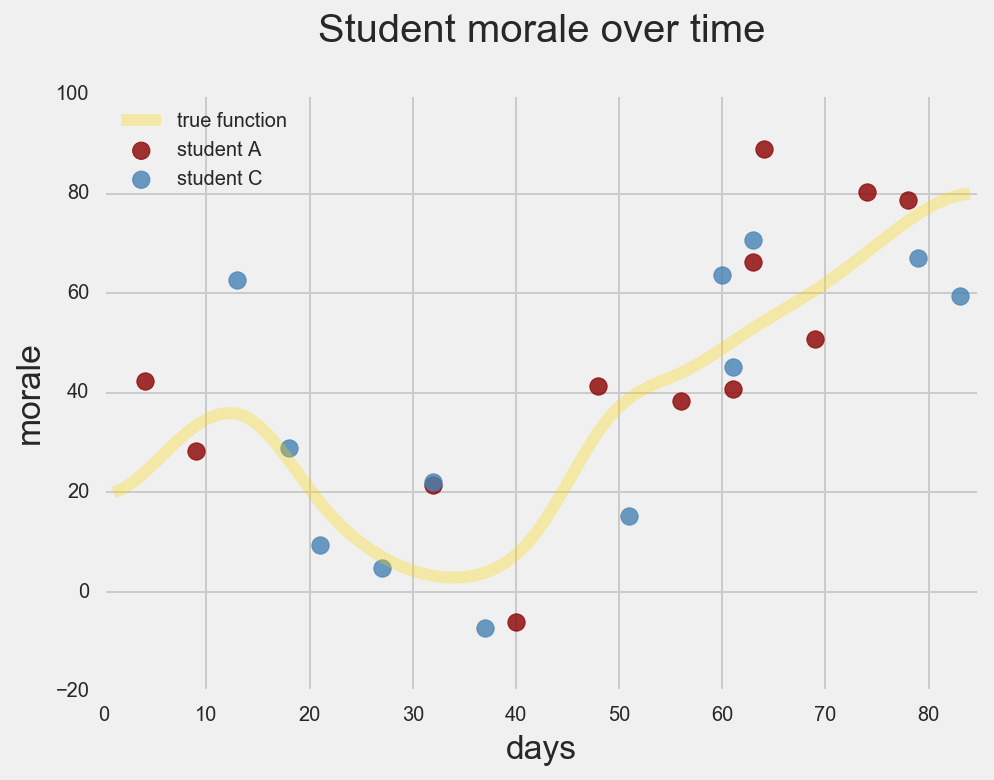

In [25]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(days, morale_true, lw=6, color='gold', alpha=0.3, label='true function')
ax.scatter(students['A']['days'], students['A']['morale'],
           s=75, color='darkred', label='student A', alpha=0.8)
ax.scatter(students['C']['days'], students['C']['morale'],
           s=75, color='steelblue', label='student C', alpha=0.8)

ax.set_xlabel('days')
ax.set_ylabel('morale')
ax.set_title('Student morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')
plt.show()

---

### Measuring more students

Below we will assess the morale of 3 different students over the days in the course at different times. We can build these simple `morale ~ time` models for each and plot.

Currently, these models are **high bias and low variance**. This is because there is a large amount of difference on average between the model predictions and the true function, but not a lot of variation in predictions at time points across our models for the 3 students.

---

### Increasing the complexity (and thus the variance) of our model

Currently we are just predicting that morale increases over time. In reality though, there is an increase, then a decrease, and then an increase again. 

Just using time alone can't fit a curve since there is only one coefficient being multiplied by time to make our morale prediction. We could, however, add more variables created from time such as $time^2$, $time^3$, etc.

The charts below show the difference in the fit when you add different numbers of "polynomial" time variables:

### $$\hat{morale} = \beta_0 + \beta_1time + \beta_2time^2$$
### $$\hat{morale} = \beta_0 + \beta_1time + \beta_2time^2 + \beta_3time^3 + \beta_4time^4$$
### $$\hat{morale} = \beta_0 + \beta_1time + ... + \beta_{16}time^{16}$$

---

### High variance typically comes with a high-complexity model

The variance between predictions typically goes up with increase in model complexity. Increasing the complexity of the model at the expense of good future predictions is known as "overfitting" the data.

Below are student A and student B fit with the 16-polynomial time model and the area showing the difference in predictions at time points between them. Compare this to the area we saw earlier with the single time term.

With an overfit model like this, variance between predictions for morale at a specific time is very high.